In [87]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy import signal
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from pmdarima import acf
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from IPython.display import Math
import datetime
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ValueError)

In [88]:
df = pd.read_csv('C:/Users/norri/Desktop/tyson_EDA.csv')
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      54039 non-null  object 
 1   y       20515 non-null  float64
dtypes: float64(1), object(1)
memory usage: 844.5+ KB


In [89]:
print('Missing Values')
print(df['y'].isnull().sum() / len(df) * 100)
print('Zeroes')
print((df['y'] == 0).sum())

Missing Values
62.03667721460426
Zeroes
34


Initially we have over half missing, as well as a few zeroes which can be problematic during forecasting. I'll drop the zeroes since they make up a small part of the dataset.

In [90]:
df = df[df.y != 0]

In [91]:
print('Missing Values')
print(df['y'].isnull().sum() / len(df) * 100)
print('Zeroes')
print((df['y'] == 0).sum())

Missing Values
62.075733728358486
Zeroes
0


In [92]:
df.nunique()

ds     446
y     3808
dtype: int64

With so many more duplicated y values, looking through the data it shows that for the same date the revenue is replicated several times over. Here I group by dates and take the average of the revenue to have a single value for revenue per date value.

In [93]:
df_a = df.groupby('ds').apply('y').mean().reset_index()
print('Missing Values')
print(df_a['y'].isnull().sum() / len(df_a) * 100)
print('Zeroes')
print((df_a['y'] == 0).sum())

Missing Values
40.582959641255606
Zeroes
0


This is something we had to do when modeling Tyson originally, but we have to drop all of the NA's, which is about 30,000 original observations.

In [94]:
df_a= df.dropna()

The date values aren't daily; they skip a day here or there, so I decided to group them into weeks.

In [95]:
df_a['date'] = pd.to_datetime(df_a['ds']) - pd.to_timedelta(7, unit='d')
weekly = df_a.groupby([pd.Grouper(key='date', freq='W')])['y'].sum().reset_index()
weekly = weekly.rename(columns={'y': 'revenue'})

C:\Users\norri\AppData\Local\Temp\ipykernel_28632\3997388910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['date'] = pd.to_datetime(df_a['ds']) - pd.to_timedelta(7, unit='d')


In [96]:
print('Missing Values')
print(weekly['revenue'].isnull().sum() / len(weekly) * 100)
print('Zeroes')
print((weekly['revenue'] == 0).sum())

Missing Values
0.0
Zeroes
7


Still seven weeks at zero, so they have to be dropped for future methods.

In [97]:
weekly = weekly[weekly.revenue != 0]

In [98]:
print('Missing Values')
print(weekly['revenue'].isnull().sum() / len(weekly) * 100)
print('Zeroes')
print((weekly['revenue'] == 0).sum())

Missing Values
0.0
Zeroes
0


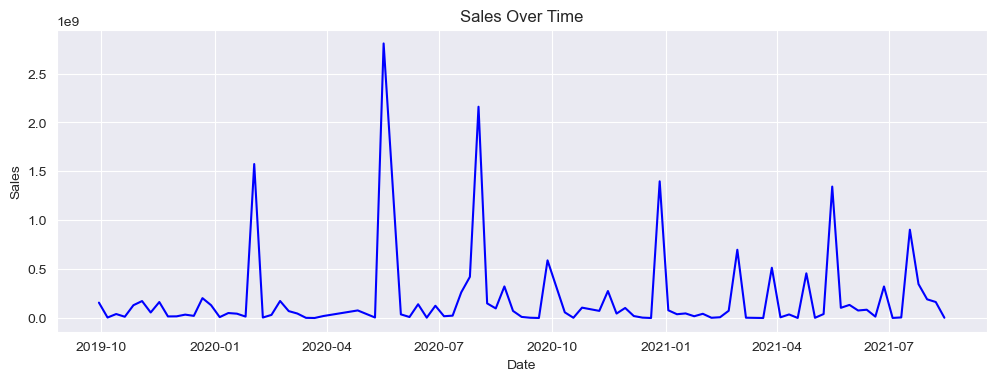

In [99]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Sales', dpi=100):
    plt.figure(figsize=(12, 4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(weekly, weekly['date'], weekly['revenue'], title='Sales Over Time')

The plot shows massive spikes and is wildly inconsistent. It appears that from the minimum to the maximum is five orders of magnitude.

In [100]:
weekly['revenue'].describe()

count    9.200000e+01
mean     2.008957e+08
std      4.486742e+08
min      3.080624e+04
25%      1.081594e+07
50%      4.619715e+07
75%      1.514249e+08
max      2.808555e+09
Name: revenue, dtype: float64

C:\Users\norri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\norri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


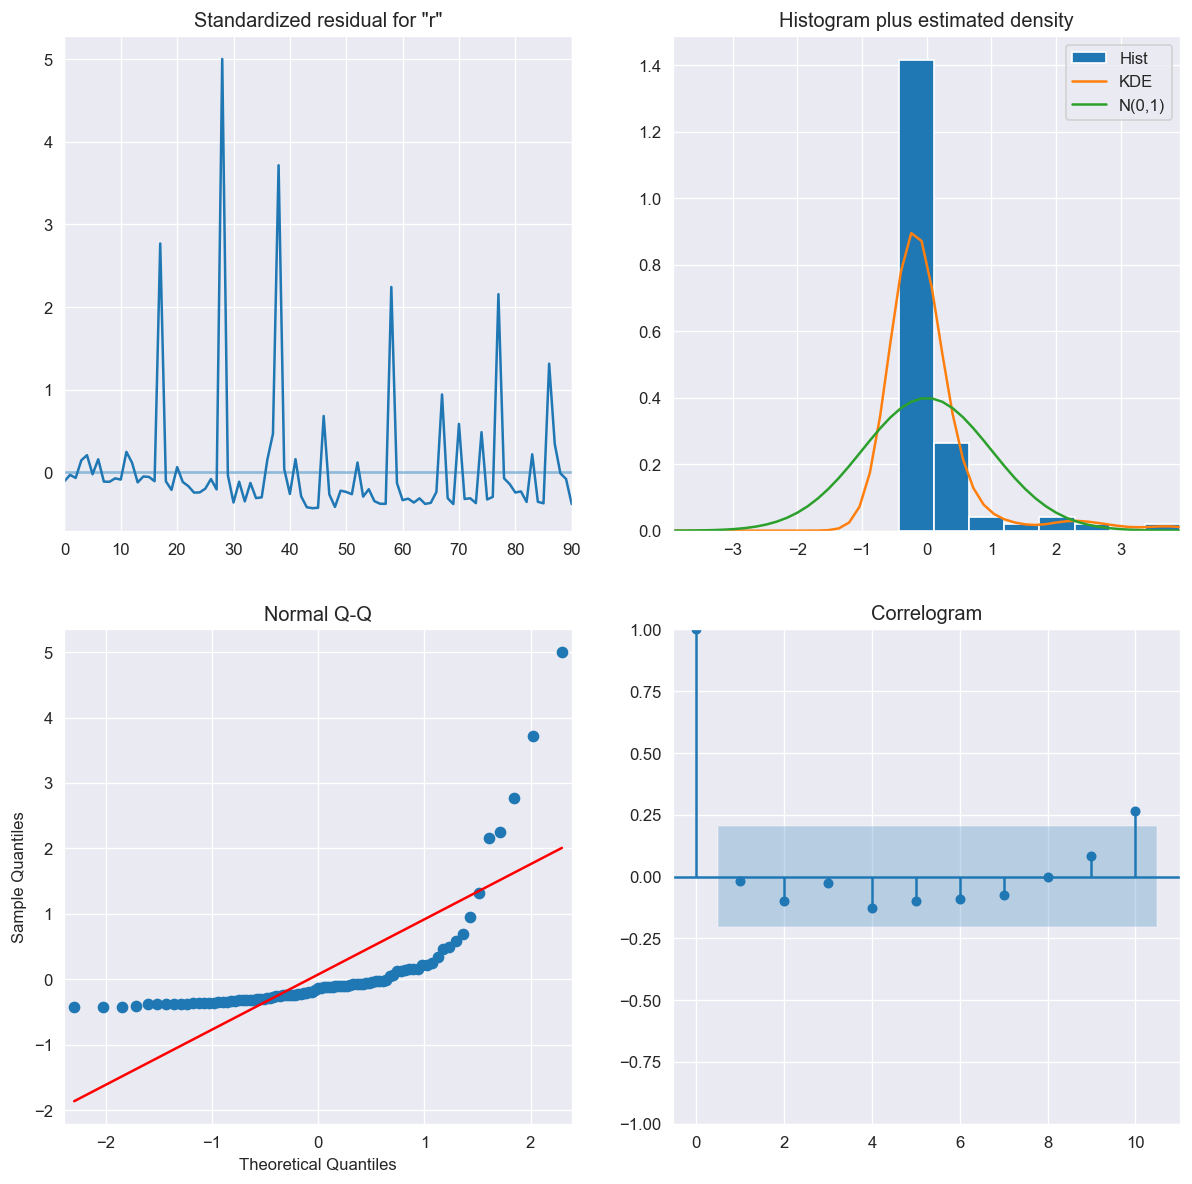

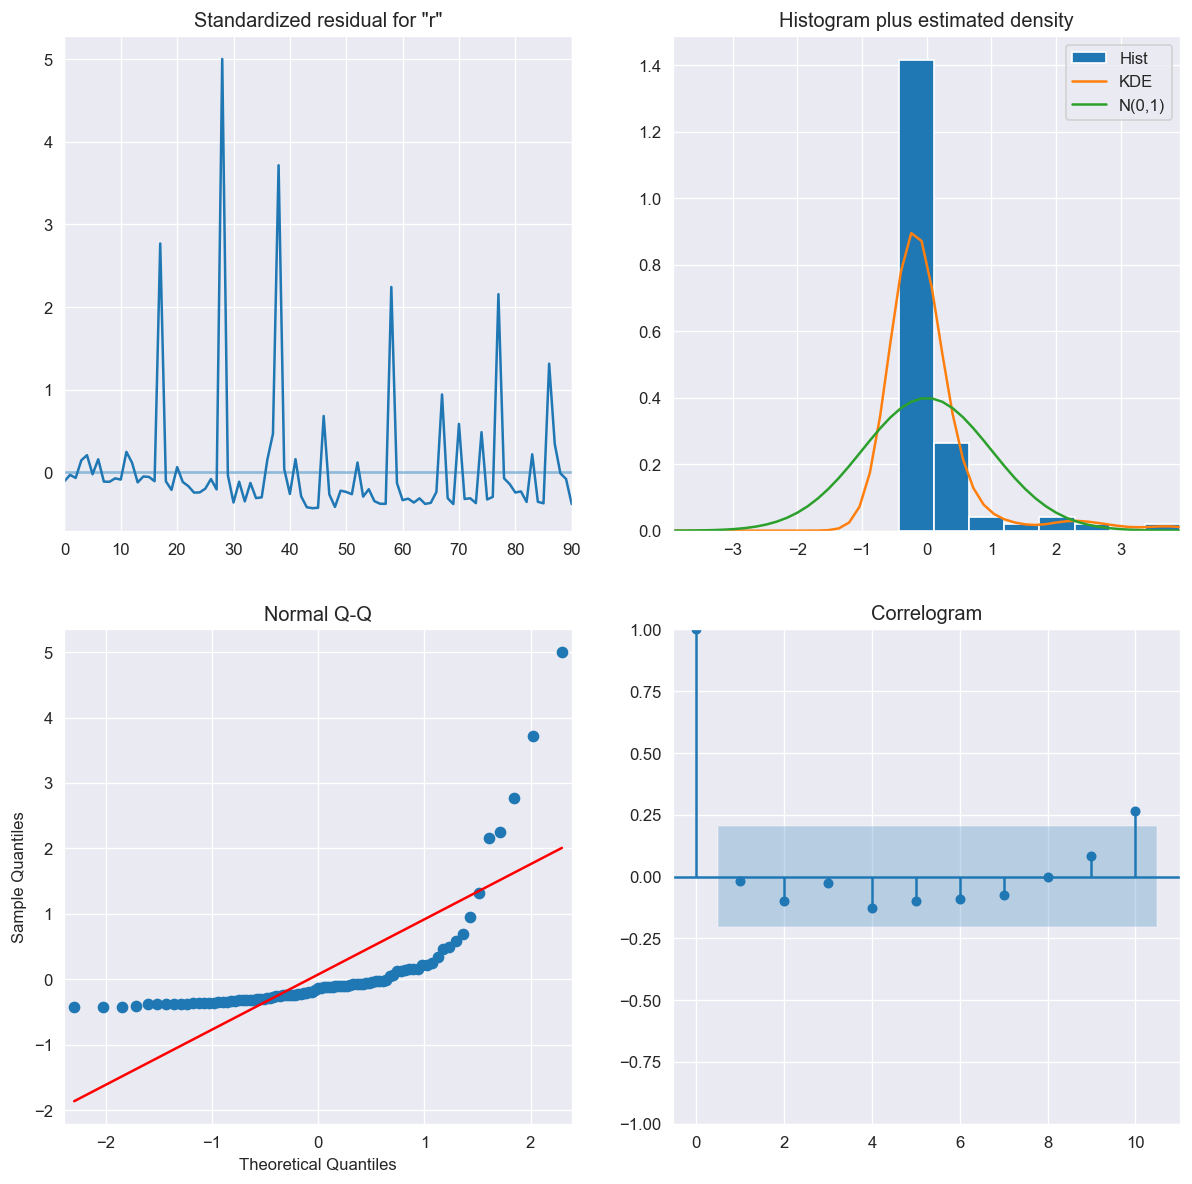

In [101]:
mod = sm.tsa.statespace.SARIMAX(weekly['revenue'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
results = mod.fit()
results.plot_diagnostics(figsize=(12, 12))

THe Q-Q plots show that ARIMA is fitting very poorly here. The following autocorrelation plot is not great, but not terrible. Still with the uncertainty the data is showing, it is hard to trust it.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

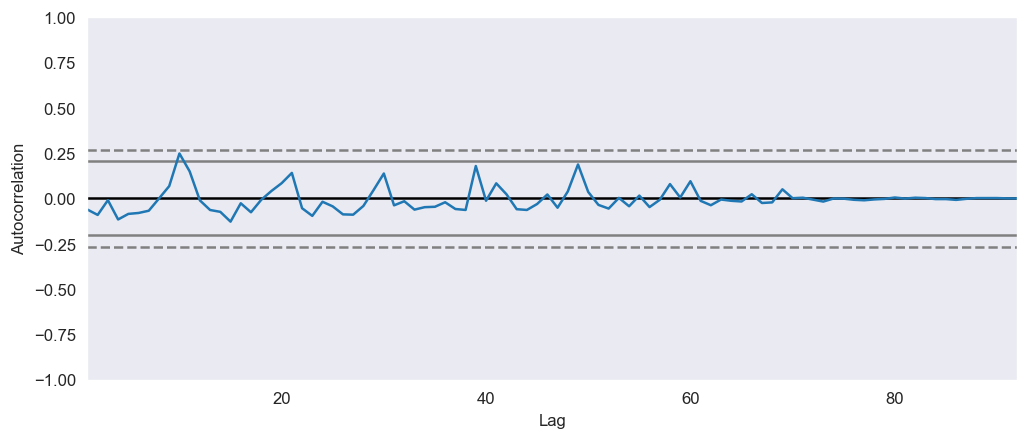

In [102]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(weekly['revenue'].tolist())

I'll give auto ARIMA a chance to perfect the parameters to see if it's any better.

In [103]:
train = weekly['revenue']
mod_auto_arima = auto_arima(train, start_p=0, d=1, start_q=0, max_p=5,
                         max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
                         max_P=5, max_D=5, max_Q=5, m=12, seasonal=True,
                         error_action='warn', trace=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=13, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3502.534, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3460.148, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3429.495, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3447.028, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3431.009, Time=0.25 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3430.961, Time=0.28 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3435.513, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3432.801, Time=0.71 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3431.293, Time=0.20 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=3426.693, Time=0.18 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=3445.685, Time=0.07 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=3428.281, Time=0.26 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=3428.226, Time=0.39 sec
 ARIMA(0,1,2)(1,1,0)[12]

In [104]:
train = weekly['revenue'][-12:]
test = weekly['revenue'][:12].reset_index() # missing pass sixteen weeks
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = mod_auto_arima.predict(n_periods=12)
fcst = pd.DataFrame(columns = ['forecast', 'test'])
fcst['forecast'] = forecast
fcst = fcst.reset_index()
fcst['test'] = test['revenue']

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=501.553, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=503.593, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=504.118, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=505.110, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=504.998, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.131 seconds


C:\Users\norri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


It's a truly terrible forecast. The 80 preceding values had no real capability of predicting the following twelve.

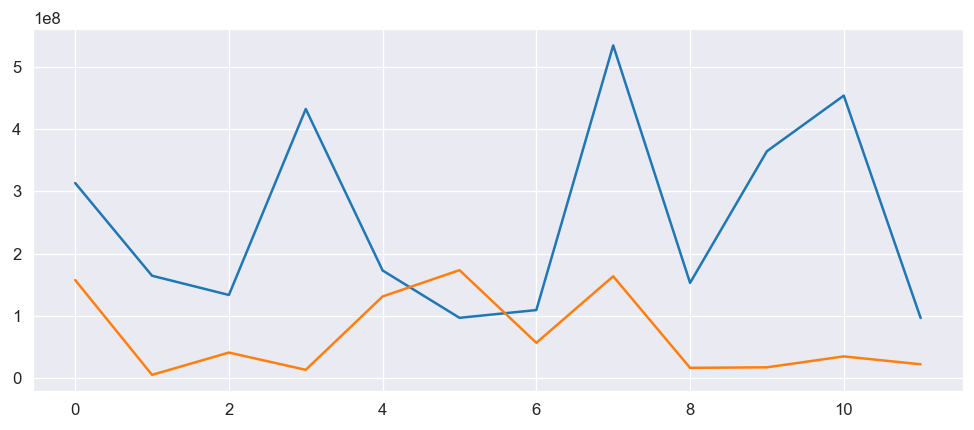

In [105]:
plt.plot(fcst['forecast'], label='forecast')
plt.plot(fcst['test'], label='Test')
plt.show()